# Experiments on VisualGenome dataset

In [2]:
# import all required codes here
import os
import pathlib
import re
import json
import nltk
import numpy as np
from collections import Counter, defaultdict
from scipy.spatial import distance
#import simple_gensim

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, TimeDistributed
from keras.layers import Lambda, Reshape, Activation
import keras.backend as K

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### The spatial relations dictionary

In [3]:
en_preps = ['in', 'on', 'at', 'to', 'above', 'below', 'over', 'under']

# Landau English prepositions
en_preps = [
    # simple spatial relations
    'at', 'on', 'in', 'on', 'off',
    'out', 'by', 'from', 'to',
    'up', 'down', 'over', 'under',
    'with', ('within', 'with in'), ('without', 'with out'), 'near',
    'neadby', ('into', 'in to'), ('onto', 'on to'), 'toward',
    'through', 'throughout', 'underneath', 'along',
    'across', ('among', 'amongst'), 'against', 'around',
    'about', 'above', ('amid', 'amidst'), 'before',
    'behind', 'below', 'beneath', 'between',
    'beside', 'outside', 'inside', ('alongside', 'along side'),
    'via', 'after', 'upon', 
    # compounds
    ('top', 'on top of'), ('between', 'in between'), ('right', 'to the right of'), ('parallel', 'parallel to'),
    ('back', 'in back of'), ('left', 'to the left of'), ('side', 'to the side'), ('perpendicular', 'perpendicular to'),
    ('front', 'in front of'),
    # temporal only
    'during', 'since', 'until', 'ago',
    # intransitivies (+ additional variations)
    'here', 'outward', ('backward', 'backwards'), ('south' , 'south of'),
    'there', ('afterward', 'afterwards'), 'away', ('east', 'east of'),
    'upward', 'upstairs', 'apart', ('west', 'west of'),
    'downward', 'downstairs', 'together', 'left',
    'inward', 'sideways', ('north', 'north of'), 'right',
]


# Herskovits projective_terms
en_preps += [(w2, w1+' the '+w2+' of')           for w1 in ['at', 'on', 'to', 'by'] for w2 in ['left', 'right'] ]
en_preps += [(w2, w1+' the '+w2+' side of')      for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['left', 'right']]
en_preps += [(w2, w1+' the '+w2+' hand side of') for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['left', 'right']]
en_preps += [(w2, w1+' the '+w2+' of')           for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['front', 'back', 'side']]
en_preps += [(w1, 'in '+w1+' of')                for w1 in ['front', 'back']]
en_preps += [(w1,)                               for w1 in ['before', 'behind']]
en_preps += [(w1, w1+' of')                      for w1 in ['left', 'right', 'back']]
en_preps += [(w1,)                               for w1 in ['above', 'below']]
en_preps += [(w1,)                               for w1 in ['over', 'under']]
en_preps += [(w2, w1+' the '+w2+' of')           for w1 in ['at', 'on', 'in', 'by'] for w2 in ['top', 'bottom']]
en_preps += [(w2, w1+' '+w2+' of')               for w1 in ['on'] for w2 in ['top']]

# missing items?
en_preps += [('next', 'next to'), ('front', 'on the front of', 'on front of', 'front of')]

# for those who lost 'the'
en_preps += [(w2, w1+' '+w2+' of')           for w1 in ['at', 'on', 'to', 'by'] for w2 in ['left', 'right'] ]
en_preps += [(w2, w1+' '+w2+' side of')      for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['left', 'right']]
en_preps += [(w2, w1+' '+w2+' hand side of') for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['left', 'right']]
en_preps += [(w2, w1+' '+w2+' of')           for w1 in ['at', 'on', 'in', 'to', 'by'] for w2 in ['front', 'back', 'side']]
en_preps += [(w2, w1+' '+w2+' of')           for w1 in ['at', 'on', 'in', 'by'] for w2 in ['top', 'bottom']]

# fix the tuple types
en_preps = [(w,) if type(w) != tuple else w for w in en_preps]

# This will create a ditionary of preposition variations to a simple tocken
composit2simple = dict()
composit2simple.update({w_alt: w[0] for w in en_preps for w_alt in w})
# every key is itself!
composit2simple.update({w: w        for w in composit2simple.values()})
# fix a common annotation with 'a', 'is', 'are'
composit2simple.update({new_w_alt: w     for w_alt, w in composit2simple.items() for new_w_alt in [w_alt + ' a', 'are ' + w_alt + ' a', 'is ' + w_alt + ' a', 'are ' + w_alt, 'is ' + w_alt]}) 


## Tests on Visual Genome

In [4]:
# place the visual genom folder in the same path as this file (or symbolic link to the folder) 
! ls visual_genome

attributes.json      qa_to_region_mapping.json	    relationship_alias.txt
attributes.json.zip  qa_to_region_mapping.json.zip  relationships.json
image_data.json      question_answers.json	    relationships.json.zip
image_data.json.zip  question_answers.json.zip	    scene_graphs.json
images2.zip	     readme_v1_4.txt		    scene_graphs.json.zip
images.zip	     region_descriptions.json	    synsets.json
object_alias.txt     region_descriptions.json.zip   synsets.json.zip
objects.json	     region_graphs.json		    VG_100K
objects.json.zip     region_graphs.json.zip	    VG_100K_2


In [5]:
# read from file
rels_from_file = json.load(open('visual_genome/relationships.json'))

# name/names correction for reading content of nodes in the dataset
name_extract = lambda x: x['names'][0].lower() if 'names' in x and len(x['names']) else x['name'].lower() if 'name' in x else '' 

In [6]:
# convert it into a set of (image, subject, predicate, object)
triplets = {
    (rels_in_image['image_id'],
     name_extract(rel['subject']),
     composit2simple[rel['predicate'].lower()] if rel['predicate'].lower() in composit2simple else rel['predicate'].lower(),
     name_extract(rel['object']))
    for rels_in_image in rels_from_file
    for rel in rels_in_image['relationships']
    if name_extract(rel['subject']) not in composit2simple and name_extract(rel['object']) not in composit2simple
}

In [37]:
for i, w in enumerate(triplets):
    print(w)
    if (i>100):
        break

(2371847, 'people', 'showing', 'tattoos')
(2405208, 'lady', 'has', 'ponytail')
(2355481, 'hole', 'in', 'road')
(2374479, 'elephant', 'in', 'grass')
(2330968, 'pants', 'on', 'person')
(2368956, 'blackberry', 'on', 'cake')
(2328369, 'cop', 'wearing', 'coat')
(2403336, 'flower', 'on', 'hat')
(2342959, 'man', 'wearing', 'sarong')
(2388001, 'wall', 'next', 'tracks')
(2319551, 'man', 'on', 'runway')
(2405530, 'chin', 'of', 'woman')
(2403261, 'giants', 'written on', 'jersey')
(2334882, 'door', 'on', 'bus')
(2365110, 'female', 'with', 'shirt')
(2394538, 'writing', 'on', 'paper')
(2404013, 'grass', 'around', 'tree')
(2397462, 'white', 'computer', 'keyboard.')
(2394730, 'man', 'has', 'balding spot')
(2320162, 'nose', 'on', 'face')
(2404639, 'cup', 'on', 'table')
(2416639, 'brick', 'in', 'brick wall')
(2318762, 'man', 'top', 'snow')
(2389686, 'nose', 'of', 'cow')
(2353872, 'hill', 'in', 'distance')
(2382901, 'clock', 'has', 'numbers')
(2394018, 'post', 'standing across', 'parking lot')
(2317034, 

In [7]:
relations_filter = set(composit2simple.values())

In [8]:
triplets_filtered = [
    (imgid, trg, rel, lnd)
    for imgid, trg, rel, lnd in triplets
    if rel in relations_filter
]

In [9]:
freq_c_rel = Counter([
    ((trg, lnd), rel)
    for imgid, trg, rel, lnd in triplets_filtered
])
freq_rel = Counter([
    rel
    for imgid, trg, rel, lnd in triplets_filtered
])
logprob_c_given_rel = {
    ((trg, lnd), rel): np.log2(freq_c_rel[((trg, lnd), rel)]) - np.log2(freq_rel[rel])
    for ((trg, lnd), rel) in freq_c_rel
}
entropy_rel = {
    rel0: sum([-logprob_c_given_rel[((trg, lnd), rel)]*(2**(logprob_c_given_rel[((trg, lnd), rel)])) for ((trg, lnd), rel) in logprob_c_given_rel if rel == rel0])
    for rel0 in relations_filter
}
entropy_rel = {
    rel: entropy_rel[rel]
    for rel in entropy_rel
    if entropy_rel[rel] > 0
}

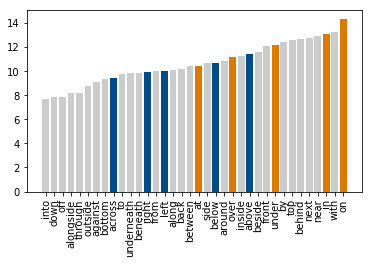

In [28]:
colordict = defaultdict(lambda: '#cccccc', [
    (w,'#DD7800') for w in ['at','in','on','over','under']] + [
    (w,'#004b89') for w in ['below','above','left','right', 'across']
])
plt.gcf().subplots_adjust(bottom=0.25)
labels, results = list(zip(*sorted(entropy_rel.items(), key=lambda x: x[1])[-36:]))
plt.bar(range(len(labels)), results, color=[colordict[w] for w in labels])
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.show()


### Language Model Preprocessing

In [12]:
# model definition
def build_model(
        max_len,
        vocab_size,
        embedding_size = 50,
        memory_size = 50,
    ):
    
    lm = Sequential([
        Embedding(vocab_size, embedding_size, input_shape=[max_len+1,]),
        LSTM(memory_size, return_sequences=True, ), 
        TimeDistributed(Dense(vocab_size, activation='softmax')),
    ])

    lm.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return lm

# perplexity calculator (for a model lm, and a given sample X)
def perplexity(lm, X):
    X_test = X[:, :-1]
    Y_sparse_test = np.expand_dims(X[:, 1:], 2) # the correct predicitons
    # predictions:
    Y_hat_test = lm.predict(X_test) # the probabilities for all possiblities
    Y_sparse_hat_test = np.array([ # the probabilities of the correct prediction
        [
            Y_hat_test[sent, word, Y_sparse_test[sent,word,0]]
            for word in range(Y_sparse_test.shape[1])
        ]
        for sent in range(Y_sparse_test.shape[0])
    ])

    return 2**(np.sum(-np.log2(Y_sparse_hat_test), 1)/np.sum(X_test!=0, 1))

In [29]:
vocab_ferq = Counter([
    w
    for words in triplets
    for w in words[1:]
])

# clean the data by removing the least frequent words from the dataset
vocab_ferq = defaultdict(int,(
    (w, freq)
    for w, freq in vocab_ferq.items()
    if freq > 100
))

vocab_ferq['<pad>'] = 0
vocab_ferq['</s>'] = 0
vocab_ferq['<s>'] = 0
vocab_ferq['<unk>'] = 0

vocab = list(vocab_ferq.keys())
word2index = defaultdict(lambda: vocab.index('<unk>'), ((w, i) for i, w in enumerate(vocab)))
max_len = max(len(s[1:]) for s in triplets)

In [30]:
# only accept triplets with a known word in dictionary:
dataset_tokenized_text = np.array([
    [word2index['<s>']] + [word2index[w] for w in s[1:]] + [word2index['</s>']] + [word2index['<pad>']]*(max_len-len(s))
    for s in triplets
    if word2index['<unk>'] not in [word2index[w] for w in s[1:]]
])


In [31]:
len(vocab_ferq), len(dataset_tokenized_text)

(2254, 1238725)

In [32]:
[vocab[w] for w in dataset_tokenized_text[0]],dataset_tokenized_text[0]

(['<s>', 'lady', 'has', 'ponytail', '</s>'],
 array([2252,    2,    3,    4, 2251]))

#### Shuffle and split the test/train data

In [33]:
# shuffle the index and then select from that
X_index = np.arange(dataset_tokenized_text.shape[0])

np.random.seed(int(np.pi*10001))
np.random.shuffle(X_index)

X = dataset_tokenized_text[X_index]

test_split = int(X.shape[0]/10)

In [34]:
for cv in range(10):
    print("The fold number {} out of 10".format(cv+1))
    X_test  = X[cv*test_split:(cv+1)*test_split]
    X_train = X[list(range(0,cv*test_split))+list(range((cv+1)*test_split,X.shape[0]))]
    
    ######## Create a downsampled training data ########
    # Available relations 
    avalable_relations = [word2index[rel] for rel in composit2simple.values() if word2index[rel]!=vocab.index('<unk>')]

    # buckets:
    bucket_size = 200
    X_train2_index_rels = {
        rel: []
        for rel in avalable_relations
    }

    # Fill the buckets:
    for i, sent in enumerate(X_train):
        if sent[2] in X_train2_index_rels and len(X_train2_index_rels[sent[2]]) < bucket_size:
            X_train2_index_rels[sent[2]].append(i)

    # Do not use small buckets at all:
    X_train2_index = np.concatenate([
        X_train2_index_rels[rel]
        for rel in X_train2_index_rels
        if len(X_train2_index_rels[rel]) == bucket_size
    ])

    # Here is the final training data for balanced training:
    X_train2 = X_train[X_train2_index]
    
    ####### the vocabulary changes for balanced training data  ########
    # this code is not optimised but it works.

    # Shared vocabulary between two trainin set
    new_vocab_index_freq = Counter(w for s in X_train2 for w in s)
    new_vocab_index = list(new_vocab_index_freq.keys())

    # Spatial vocabulary
    spl_vocab = list(set([w for w in composit2simple.values() if w in vocab]))
    spl_vocab_index = [word2index[w] for w in spl_vocab if word2index[w] in new_vocab_index]
    
    
    ########## Create test collections! ########
    sample_bucket_size = 20

    # initialise the buckets:
    X_test2_index_rels = {
        rel: []
        for rel in spl_vocab_index
    }

    # put each sample in its bucket:
    for i, sent in enumerate(X_test):
        if sent[2] in X_test2_index_rels and \
            len(X_test2_index_rels[sent[2]]) < sample_bucket_size and \
            len([w for w in sent if w not in new_vocab_index])==0:
            X_test2_index_rels[sent[2]].append(i)


    valid_test_rels = [rel for rel in X_test2_index_rels if new_vocab_index_freq[rel] >= 200 and len(X_test2_index_rels[rel]) == sample_bucket_size]
    # alphabetic sort sort
    valid_test_rels = [rel for _, rel in sorted([(vocab[r], r) for r in valid_test_rels])]

    X_test2_index = np.concatenate([
        X_test2_index_rels[rel]
        for rel in X_test2_index_rels
        if rel in valid_test_rels
        if len(X_test2_index_rels[rel]) == sample_bucket_size
    ])

    X_test2 = X_test[X_test2_index]

    print('Number of groups of samples:', len(valid_test_rels))
    print('Size of samples:', sample_bucket_size)
    print('Number of total samples:', len(X_test2))
    
    
    ######## Training the language model ########
    # some data/model hyperparameters:
    max_len = max_len
    vocab_size = len(vocab)
    embedding_size = 300
    memory_size = 300
    
    # training model 1
    lm1 = build_model(
        max_len = max_len,
        vocab_size = vocab_size,
    )
    lm1.fit(X_train[:, :-1], np.expand_dims(X_train[:, 1:], 2), epochs=40, batch_size=1024)
    
    # training model 2
    lm2 = build_model(
        max_len = max_len,
        vocab_size = vocab_size,
    )
    lm2.fit(X_train2[:, :-1], np.expand_dims(X_train2[:, 1:], 2), epochs=40, batch_size=32)
    
    
    ####### reporting procedures #######
    
    # these functions could be optimised, in this shape they are using some global variables ...
    def report(lm, X_test, rels):
        X_test_spl = [
            [w for w in sent if w in rels][0]
            for sent in X_test
        ]

        results_sum= defaultdict(int)
        results_count= defaultdict(float)
        results_sum_x = defaultdict(lambda: np.zeros(len(rels)))

        X_test_X = [
            np.array([[X_test[i][0],X_test[i][1], r, X_test[i][3], X_test[i][4]] for r in rels])
            for i,rel in enumerate(X_test_spl)
        ]

        for term, pp, xchanges in zip(X_test_spl, list(perplexity(lm, X_test).flatten()), X_test_X):
            results_sum_x[term] += np.log2(perplexity(lm, xchanges).flatten())
            results_sum[term] += np.log2(pp)
            results_count[term] += 1

        results = [
            [vocab[term], 2**(results_sum[term]/results_count[term]), results_count[term]] + \
            [2**(results_sum_x[term][r]/results_count[term]) for r in range(len(rels))]
            for term in results_sum
        ]

        #results.sort(key=lambda x: x[1], reverse=True)

        return(results)

    def report_to_string(results, rels):
        output = ''
        output += ("{}\t{}\t{}"+"\t{}"*len(rels)).format(*(['term', 'sample_pp', 'sample_size']+[vocab[rel] for rel in rels])) + '\n'
        for x in results:
            output += ("{}\t{:.2f}\t{}"+"\t{:.2f}"*len(rels)).format(*x) + '\n'

        return output
    
    ######### generate the reports #########
    r = report(lm1, X_test2, valid_test_rels)

    r_voc = [
        word2index[rrr[0]]
        for rrr in r
    ]
    r_ = np.array([
        rrr[3:]
        for rrr in r
    ])

    # fix the order alphabetically again (on vertical labels)
    r1 = r_[[r_voc.index(w) for w in valid_test_rels]]

    print(report_to_string(r, valid_test_rels), file=open('reports/o_matrix_fold_{}.csv'.format(cv+1), 'w'))

    r = report(lm2, X_test2, valid_test_rels)

    r_voc = [
        word2index[rrr[0]]
        for rrr in r
    ]
    r_ = np.array([
        rrr[3:]
        for rrr in r
    ])

    # fix the order alphabetically again (on vertical labels)
    r2 = r_[[r_voc.index(w) for w in valid_test_rels]]

    print(report_to_string(r, valid_test_rels), file=open('reports/b_matrix_fold_{}.csv'.format(cv+1), 'w'))

    ######## Report on preprocessing effect on frequencies ########
    vocab_freq_after_preprocessing = Counter([
        vocab[w]
        for sent in X
        for w in sent
        if vocab[w] in set(composit2simple.values())
    ])

    vocab_freq_after_preprocessing_train = Counter([
        vocab[w]
        for sent in X_train
        for w in sent
        if vocab[w] in set(composit2simple.values())
    ])

    vocab_freq_after_preprocessing_test = Counter([
        vocab[w]
        for sent in X_test
        for w in sent
        if vocab[w] in set(composit2simple.values())
    ])

    vocab_freq_after_preprocessing_train2 = Counter([
        vocab[w]
        for sent in X_train2
        for w in sent
        if vocab[w] in set(composit2simple.values())
    ])

    vocab_freq_after_preprocessing_test2 = Counter([
        vocab[w]
        for sent in X_test2
        for w in sent
        if vocab[w] in set(composit2simple.values())
    ])
    
    freq_report_file = open('reports/frequencies_fold_{}.csv'.format(cv+1), 'w')
    print("{}\t{}\t{}\t{}\t{}\t{}\t{}".format('term', 'dataset', 'pre-processing', 'train_original', 'train_balanced', 'test_source', 'test_sampled'),file=freq_report_file)
    for w,freq in vocab_freq_after_preprocessing.items():
        print("{}\t{}\t{}\t{}\t{}\t{}\t{}".format(
            w,
            vocab_ferq[w],
            freq,
            vocab_freq_after_preprocessing_train[w],
            vocab_freq_after_preprocessing_train2[w],
            vocab_freq_after_preprocessing_test[w],
            vocab_freq_after_preprocessing_test2[w],
        ),file=freq_report_file)
    freq_report_file.close()
    
    np.save('saved_data/train_fold{}.npy'.format(cv+1), X_train)
    np.save('saved_data/train2_fold{}.npy'.format(cv+1), X_train2)
    np.save('saved_data/test_fold{}.npy'.format(cv+1), X_test)
    np.save('saved_data/test2_fold{}.npy'.format(cv+1), X_test2)

    lm1.save('saved_data/lm_o_fold{}.h5'.format(cv+1))
    lm2.save('saved_data/lm_b_fold{}.h5'.format(cv+1))
    
np.save('saved_data/vocabulary.npy', vocab)

    

The fold number 1 out of 10
Number of groups of samples: 35
Size of samples: 20
Number of total samples: 700
Epoch 1/40
1114853/1114853 [==============================] - 27s - loss: 4.2094    
Epoch 2/40
1114853/1114853 [==============================] - 19s - loss: 3.5292    
Epoch 3/40
1114853/1114853 [==============================] - 19s - loss: 3.3830    
Epoch 4/40
1114853/1114853 [==============================] - 19s - loss: 3.2874    
Epoch 5/40
1114853/1114853 [==============================] - 20s - loss: 3.2152    
Epoch 6/40
1114853/1114853 [==============================] - 20s - loss: 3.1690    
Epoch 7/40
1114853/1114853 [==============================] - 20s - loss: 3.1372    
Epoch 8/40
1114853/1114853 [==============================] - 21s - loss: 3.1145    
Epoch 9/40
1114853/1114853 [==============================] - 20s - loss: 3.0971    
Epoch 10/40
1114853/1114853 [==============================] - 20s - loss: 3.0836    
Epoch 11/40
1114853/1114853 [===========

1114853/1114853 [==============================] - 20s - loss: 3.0402    
Epoch 17/40
1114853/1114853 [==============================] - 20s - loss: 3.0355    
Epoch 18/40
1114853/1114853 [==============================] - 20s - loss: 3.0314    
Epoch 19/40
1114853/1114853 [==============================] - 20s - loss: 3.0276    
Epoch 20/40
1114853/1114853 [==============================] - 20s - loss: 3.0241    
Epoch 21/40
1114853/1114853 [==============================] - 20s - loss: 3.0210    
Epoch 22/40
1114853/1114853 [==============================] - 20s - loss: 3.0181    
Epoch 23/40
1114853/1114853 [==============================] - 20s - loss: 3.0154    
Epoch 24/40
1114853/1114853 [==============================] - 20s - loss: 3.0129    
Epoch 25/40
1114853/1114853 [==============================] - 20s - loss: 3.0106    
Epoch 26/40
1114853/1114853 [==============================] - 20s - loss: 3.0085    
Epoch 27/40
1114853/1114853 [==============================] - 20s

1114853/1114853 [==============================] - 20s - loss: 2.9955    
Epoch 34/40
1114853/1114853 [==============================] - 20s - loss: 2.9942    
Epoch 35/40
1114853/1114853 [==============================] - 20s - loss: 2.9931    
Epoch 36/40
1114853/1114853 [==============================] - 20s - loss: 2.9919    
Epoch 37/40
1114853/1114853 [==============================] - 20s - loss: 2.9908    
Epoch 38/40
1114853/1114853 [==============================] - 20s - loss: 2.9899    
Epoch 39/40
1114853/1114853 [==============================] - 20s - loss: 2.9888    
Epoch 40/40
1114853/1114853 [==============================] - 20s - loss: 2.9879    
Epoch 1/40
7000/7000 [==============================] - 3s - loss: 5.5222     
Epoch 2/40
7000/7000 [==============================] - 1s - loss: 4.4891     
Epoch 3/40
7000/7000 [==============================] - 1s - loss: 4.1855     
Epoch 4/40
7000/7000 [==============================] - 1s - loss: 4.0299     
Epoch 5/

7000/7000 [==============================] - 1s - loss: 3.7233     
Epoch 11/40
7000/7000 [==============================] - 1s - loss: 3.7041     
Epoch 12/40
7000/7000 [==============================] - 1s - loss: 3.6881     
Epoch 13/40
7000/7000 [==============================] - 1s - loss: 3.6725     
Epoch 14/40
7000/7000 [==============================] - 1s - loss: 3.6569     
Epoch 15/40
7000/7000 [==============================] - 1s - loss: 3.6380     
Epoch 16/40
7000/7000 [==============================] - 1s - loss: 3.6181     
Epoch 17/40
7000/7000 [==============================] - 1s - loss: 3.5962     
Epoch 18/40
7000/7000 [==============================] - 1s - loss: 3.5741     
Epoch 19/40
7000/7000 [==============================] - 1s - loss: 3.5519     
Epoch 20/40
7000/7000 [==============================] - 1s - loss: 3.5310     
Epoch 21/40
7000/7000 [==============================] - 1s - loss: 3.5099     
Epoch 22/40
7000/7000 [=============================

7000/7000 [==============================] - 1s - loss: 3.3303     
Epoch 29/40
7000/7000 [==============================] - 1s - loss: 3.3147     
Epoch 30/40
7000/7000 [==============================] - 1s - loss: 3.2992     
Epoch 31/40
7000/7000 [==============================] - 1s - loss: 3.2851     
Epoch 32/40
7000/7000 [==============================] - 1s - loss: 3.2706     
Epoch 33/40
7000/7000 [==============================] - 1s - loss: 3.2567     
Epoch 34/40
7000/7000 [==============================] - 1s - loss: 3.2430     
Epoch 35/40
7000/7000 [==============================] - 1s - loss: 3.2286     
Epoch 36/40
7000/7000 [==============================] - 1s - loss: 3.2162     
Epoch 37/40
7000/7000 [==============================] - 1s - loss: 3.2025     
Epoch 38/40
7000/7000 [==============================] - 1s - loss: 3.1898     
Epoch 39/40
7000/7000 [==============================] - 1s - loss: 3.1767     
Epoch 40/40
7000/7000 [=============================

1114853/1114853 [==============================] - 20s - loss: 3.2366    
Epoch 5/40
1114853/1114853 [==============================] - 20s - loss: 3.1911    
Epoch 6/40
1114853/1114853 [==============================] - 20s - loss: 3.1586    
Epoch 7/40
1114853/1114853 [==============================] - 20s - loss: 3.1335    
Epoch 8/40
1114853/1114853 [==============================] - 20s - loss: 3.1142    
Epoch 9/40
1114853/1114853 [==============================] - 20s - loss: 3.0985    
Epoch 10/40
1114853/1114853 [==============================] - 20s - loss: 3.0861    
Epoch 11/40
1114853/1114853 [==============================] - 20s - loss: 3.0758    
Epoch 12/40
1114853/1114853 [==============================] - 20s - loss: 3.0672    
Epoch 13/40
1114853/1114853 [==============================] - 20s - loss: 3.0597    
Epoch 14/40
1114853/1114853 [==============================] - 20s - loss: 3.0530    
Epoch 15/40
1114853/1114853 [==============================] - 20s - lo

1114853/1114853 [==============================] - 19s - loss: 3.0250    
Epoch 22/40
1114853/1114853 [==============================] - 19s - loss: 3.0223    
Epoch 23/40
1114853/1114853 [==============================] - 20s - loss: 3.0195    
Epoch 24/40
1114853/1114853 [==============================] - 20s - loss: 3.0170    
Epoch 25/40
1114853/1114853 [==============================] - 19s - loss: 3.0147    
Epoch 26/40
1114853/1114853 [==============================] - 20s - loss: 3.0125    
Epoch 27/40
1114853/1114853 [==============================] - 20s - loss: 3.0105    
Epoch 28/40
1114853/1114853 [==============================] - 20s - loss: 3.0085    
Epoch 29/40
1114853/1114853 [==============================] - 20s - loss: 3.0067    
Epoch 30/40
1114853/1114853 [==============================] - 20s - loss: 3.0049    
Epoch 31/40
1114853/1114853 [==============================] - 19s - loss: 3.0033    
Epoch 32/40
1114853/1114853 [==============================] - 20s

1114853/1114853 [==============================] - 20s - loss: 2.9903    
Epoch 39/40
1114853/1114853 [==============================] - 20s - loss: 2.9892    
Epoch 40/40
1114853/1114853 [==============================] - 20s - loss: 2.9882    
Epoch 1/40
7000/7000 [==============================] - 7s - loss: 5.5535     
Epoch 2/40
7000/7000 [==============================] - 1s - loss: 4.4599     
Epoch 3/40
7000/7000 [==============================] - 1s - loss: 4.1469     
Epoch 4/40
7000/7000 [==============================] - 1s - loss: 3.9867     
Epoch 5/40
7000/7000 [==============================] - 1s - loss: 3.8838     
Epoch 6/40
7000/7000 [==============================] - 1s - loss: 3.8293     
Epoch 7/40
7000/7000 [==============================] - 1s - loss: 3.7868     
Epoch 8/40
7000/7000 [==============================] - 2s - loss: 3.7494     
Epoch 9/40
7000/7000 [==============================] - 1s - loss: 3.7162     
Epoch 10/40
7000/7000 [====================

7000/7000 [==============================] - 2s - loss: 3.5849     
Epoch 17/40
7000/7000 [==============================] - 2s - loss: 3.5658     
Epoch 18/40
7000/7000 [==============================] - 2s - loss: 3.5461     
Epoch 19/40
7000/7000 [==============================] - 2s - loss: 3.5245     
Epoch 20/40
7000/7000 [==============================] - 1s - loss: 3.5023     
Epoch 21/40
7000/7000 [==============================] - 1s - loss: 3.4811     
Epoch 22/40
7000/7000 [==============================] - 1s - loss: 3.4597     
Epoch 23/40
7000/7000 [==============================] - 1s - loss: 3.4396     
Epoch 24/40
7000/7000 [==============================] - 1s - loss: 3.4191     
Epoch 25/40
7000/7000 [==============================] - 2s - loss: 3.4014     
Epoch 26/40
7000/7000 [==============================] - 1s - loss: 3.3849     
Epoch 27/40
7000/7000 [==============================] - 2s - loss: 3.3675     
Epoch 28/40
7000/7000 [=============================

In [484]:
for cv in range(10):
    lm1 = load_model('saved_data00/lm_o_fold{}.h5'.format(cv+1))
    lm2 = load_model('saved_data00/lm_b_fold{}.h5'.format(cv+1))
    
    X_train2 = np.load('saved_data00/train2_fold{}.npy'.format(cv+1))
    X_test2 = np.load('saved_data00/test2_fold{}.npy'.format(cv+1))

    
    # these functions could be optimised, in this shape they are using some global variables ...
    def report(lm, X_test, rels):
        X_test_spl = [
            [w for w in sent if w in rels][0]
            for sent in X_test
        ]

        results_sum= defaultdict(int)
        results_count= defaultdict(float)
        results_sum_x = defaultdict(lambda: np.zeros(len(rels)))

        X_test_X = [
            np.array([[X_test[i][0],X_test[i][1], r, X_test[i][3], X_test[i][4]] for r in rels])
            for i,rel in enumerate(X_test_spl)
        ]

        for term, pp, xchanges in zip(X_test_spl, list(perplexity(lm, X_test).flatten()), X_test_X):
            results_sum_x[term] += np.log2(perplexity(lm, xchanges).flatten())
            results_sum[term] += np.log2(pp)
            results_count[term] += 1

        results = [
            [vocab[term], 2**(results_sum[term]/results_count[term]), results_count[term]] + \
            [2**(results_sum_x[term][r]/results_count[term]) for r in range(len(rels))]
            for term in results_sum
        ]

        #results.sort(key=lambda x: x[1], reverse=True)

        return(results)

    def report_to_string(results, rels):
        output = ''
        output += ("{}\t{}\t{}"+"\t{}"*len(rels)).format(*(['term', 'sample_pp', 'sample_size']+[vocab[rel] for rel in rels])) + '\n'
        for x in results:
            output += ("{}\t{:.2f}\t{}"+"\t{:.2f}"*len(rels)).format(*x) + '\n'

        return output
    
    ######### generate the reports #########
    r = report(lm1, X_train2, valid_test_rels)

    r_voc = [
        word2index[rrr[0]]
        for rrr in r
    ]
    r_ = np.array([
        rrr[3:]
        for rrr in r
    ])

    # fix the order alphabetically again (on vertical labels)
    r1 = r_[[r_voc.index(w) for w in valid_test_rels]]

    print(report_to_string(r, valid_test_rels), file=open('reports00/o_train_matrix_fold_{}.csv'.format(cv+1), 'w'))

    r = report(lm2, X_train2, valid_test_rels)

    r_voc = [
        word2index[rrr[0]]
        for rrr in r
    ]
    r_ = np.array([
        rrr[3:]
        for rrr in r
    ])

    # fix the order alphabetically again (on vertical labels)
    r2 = r_[[r_voc.index(w) for w in valid_test_rels]]

    print(report_to_string(r, valid_test_rels), file=open('reports00/b_train_matrix_fold_{}.csv'.format(cv+1), 'w'))


In [1]:
1

1